In [22]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import seaborn
import copy
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (17,13)

# Generate Input Data

$$x = [0,1]$$
$$y = 2sin(2\pi x)$$

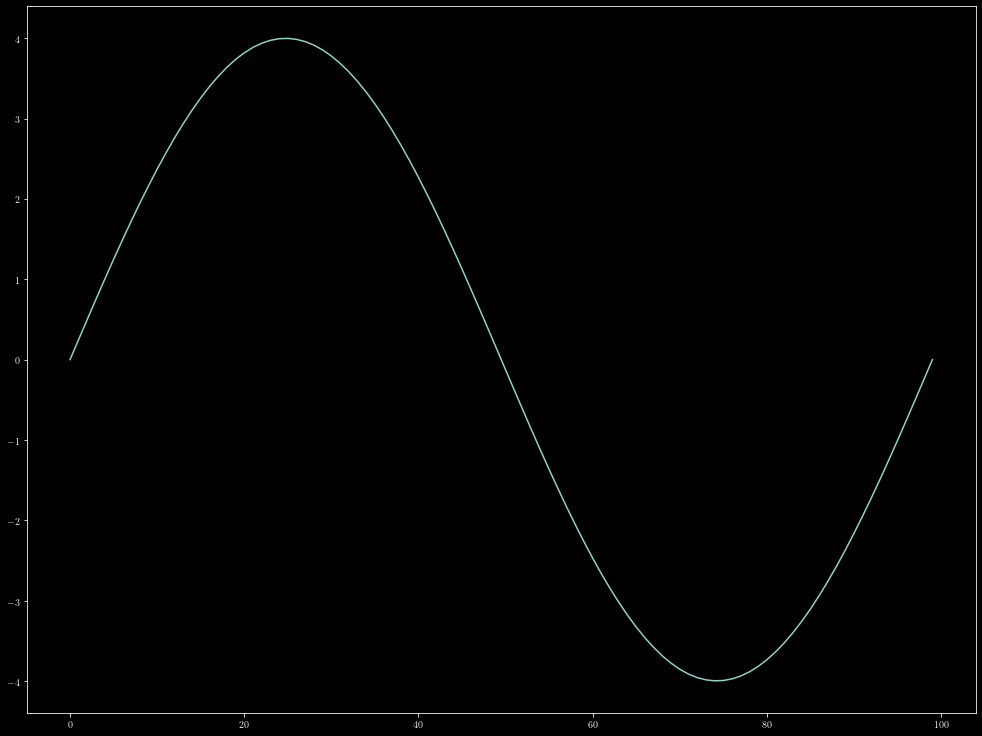

In [23]:
x = np.linspace(0, 1, 100)
y_true = 4.0*np.sin(2.0*np.pi*x)
plt.plot(y_true)

### Noise
Gaussian noise proportional to the input data
$$ Noise = N(0.0, x + 0.5) $$

In [24]:
y = np.zeros(len(x))
for idx,i in enumerate(x):
    y[idx] = 4.0*np.sin(2.0*np.pi*i) + np.random.normal(0.0, i+0.0)

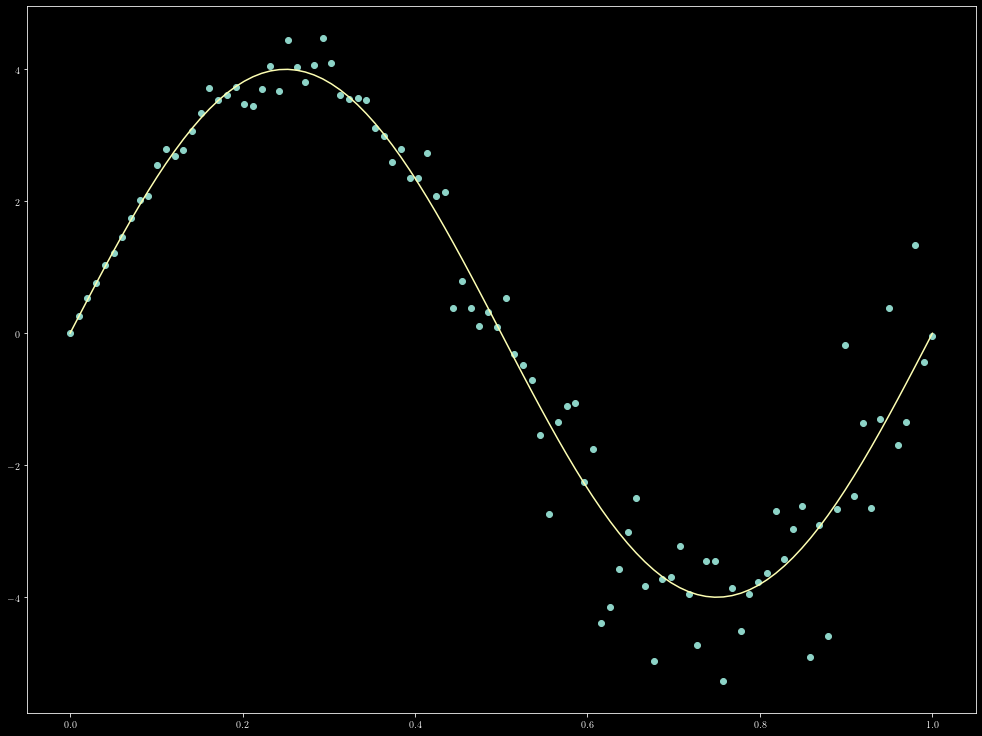

In [25]:
plt.plot(x, y, 'o')
plt.plot(x, y_true)

## Hetroscedastic GP

### Step-1: Learn GP1 : $x\rightarrow t$

In [26]:
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 114.56794472367113
Optimization restart 2/5, f = 114.56794472367054
Optimization restart 3/5, f = 114.5679447237251
Optimization restart 4/5, f = 114.56794472375478
Optimization restart 5/5, f = 114.56794472367193


In [27]:
m, v = gp1.predict(x.reshape(-1,1))

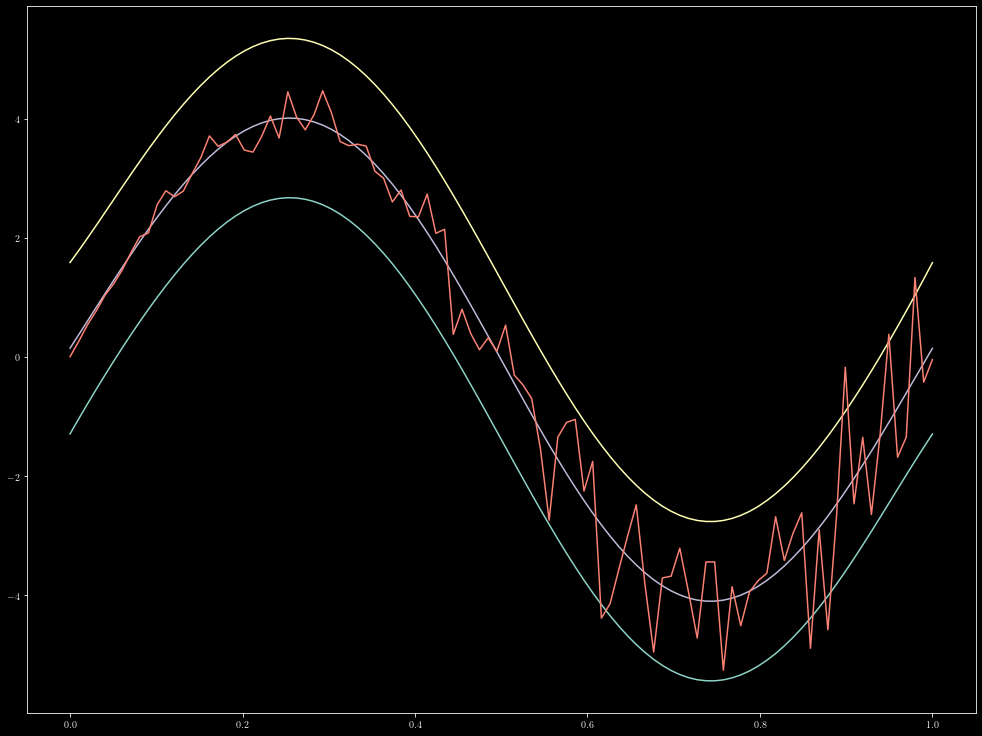

In [28]:
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwm = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x, dwm)
plt.plot(x, up)
plt.plot(x, m)
plt.plot(x, y)

### Step-2: Given the learnt GP1 estimate the emperical noise level for the training data

1. Would we use mean as a estimate or sample from the predicted mean and variace ?
- We need to use the mean and variance learnt by the GP to generate sample that we use to emperically estimate the variance.

In [50]:
m, v = gp1.predict(x.reshape(-1,1))
samples = 10
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, samples):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/samples
z = np.log(variance_noise)

### Step-3: Learn GP-2 to learn the mapping between training data and noise

In [51]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 221.27058082996712
Optimization restart 2/10, f = 221.27058087102617
Optimization restart 3/10, f = 222.00202371287855
Optimization restart 4/10, f = 221.27058082784475
Optimization restart 5/10, f = 221.27058082832372
Optimization restart 6/10, f = 221.27058082784492
Optimization restart 7/10, f = 221.27058084838487
Optimization restart 8/10, f = 221.270580829599
Optimization restart 9/10, f = 221.27058082833216
Optimization restart 10/10, f = 221.27058083629066


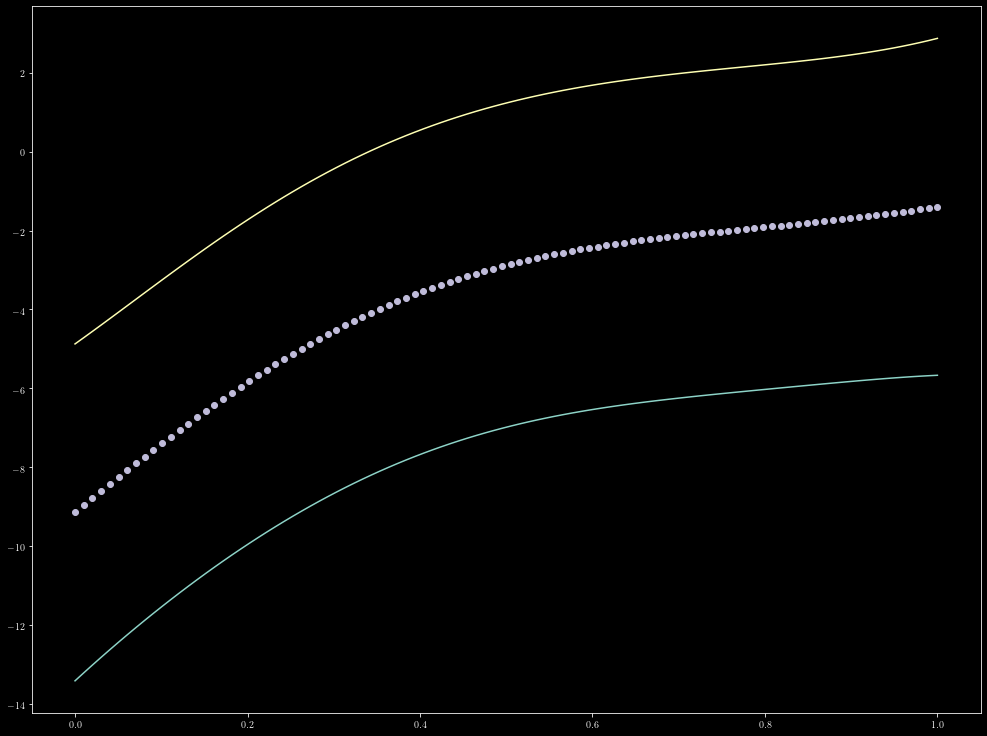

In [52]:
m_n, v_n = gp2.predict(x.reshape(-1,1))
plt.plot(x, m_n.reshape(-1) - 2.0*np.sqrt(v_n.reshape(-1)))
plt.plot(x, m_n.reshape(-1) + 2.0*np.sqrt(v_n.reshape(-1)))
plt.plot(x, m_n, 'o')

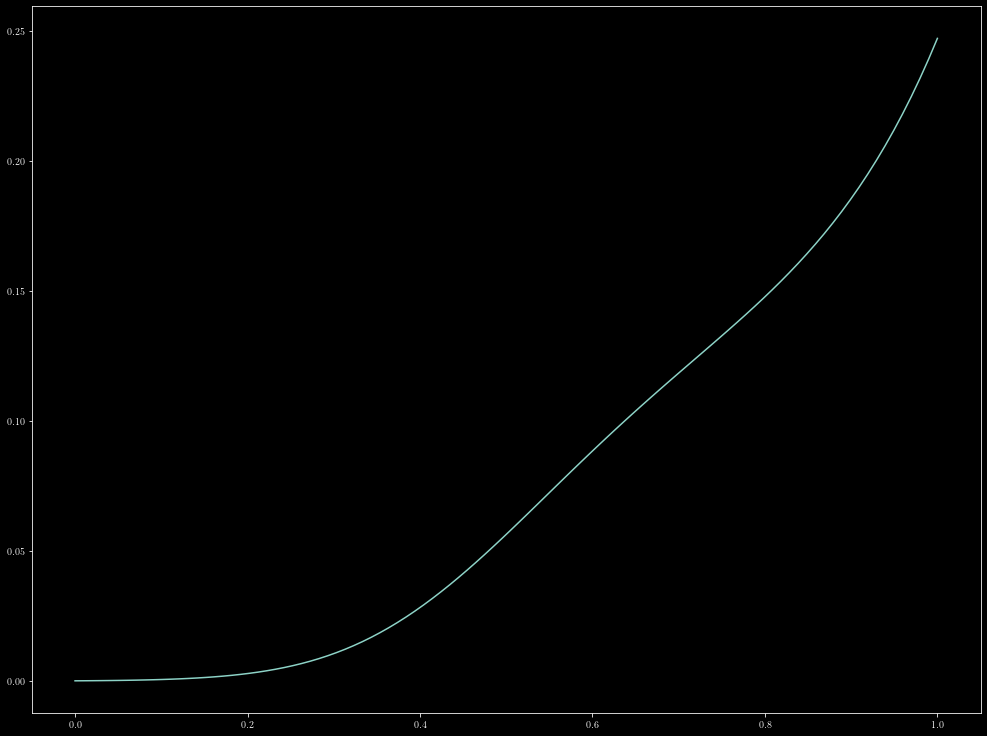

In [53]:
plt.plot(x, np.exp(m_n))

### Step 4: Learn GP3 using GP2 to predict noise

In [54]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

Optimization restart 1/10, f = -15.83434876012543
Optimization restart 2/10, f = -12.996629349074425
Optimization restart 3/10, f = -8.260639733020511
Optimization restart 4/10, f = -15.723112186183535
Optimization restart 5/10, f = -9.66588605539119
Optimization restart 6/10, f = -5.8683443621835565
Optimization restart 7/10, f = -15.834394483154213
Optimization restart 8/10, f = -6.919972813262291
Optimization restart 9/10, f = -7.089443000540726
Optimization restart 10/10, f = -13.394147181900259


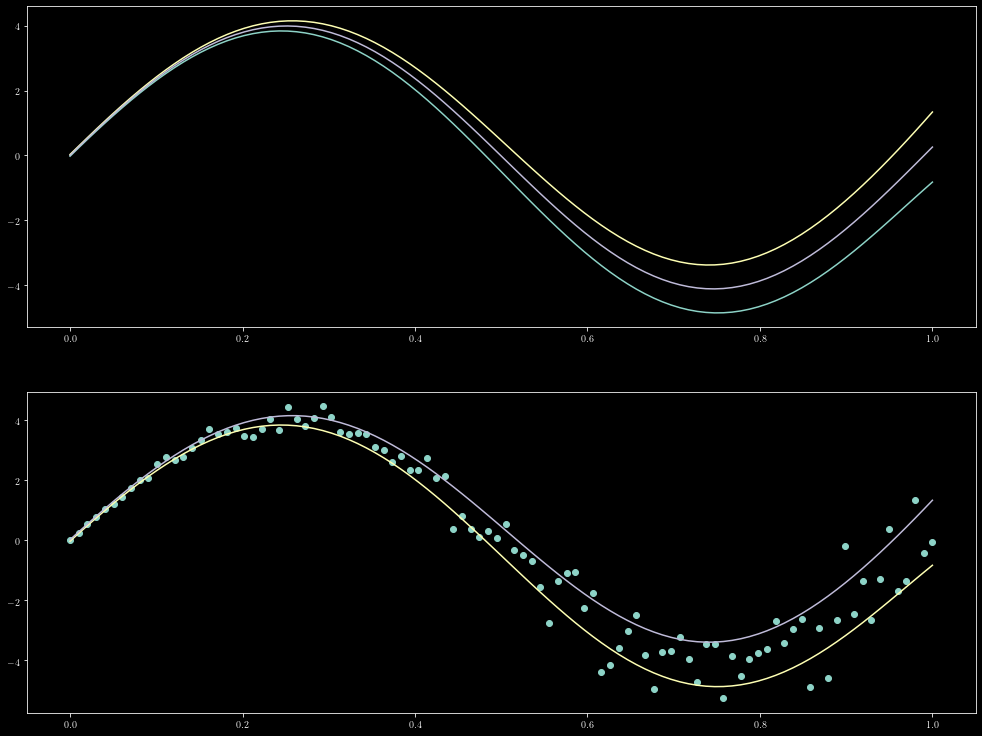

In [55]:
m, v = gp3.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwm = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.subplot(2,1,1)
plt.plot(x, dwm)
plt.plot(x, up)
plt.plot(x, m)
plt.subplot(2,1,2)
plt.plot(x,y,'o')
plt.plot(x, dwm)
plt.plot(x, up)

In [56]:
gp1 = copy.deepcopy(gp3)